# Proposal 1

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.training import CEWCV1
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 5
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = f"class_saturation/{N_EXPERIENCES}"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/proposal_1.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

In [8]:
best_hyperparameters = {
    'ewc_lambda_l1': 0.1,
    'ewc_lambda_l2': 1.0,
    'threshold': 1e-05,
}

## Evaluation metrics definition

In [9]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [10]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [11]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = CEWCV1(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/5 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 113.28it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 118.3000
	Loss_MB/train_phase/train_stream/Task000 = 8.2609
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0001
	Time_Epoch/train_phase/train_stream/Task000 = 4.1406
100%|██████████| 469/469 [00:04<00:00, 114.96it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 114.7000
	Loss_MB/train_phase/train_stream/Task000 = 13.5791
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.0799
100%|██████████| 469/469 [00:04<00:00, 109.74it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 121.8000
	Loss_MB/train_phase/train_stream/Task000 = 17.6114
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.2738
100%|██████████| 469/469 [00:04<00:00, 107.64it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/trai

 20%|██        | 1/5 [00:29<01:56, 29.16s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3049
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16be307c0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 693.2578
	EvalStream/Acc_Matrix = 
tensor([[0.9150, 0.1037, 0.1483, 0.1063, 0.1178],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 2.3724
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 335.7344
	StreamBWT/eval_phase/test_stream = 0.0000
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2782
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.2039
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.2

 40%|████      | 2/5 [00:57<01:26, 28.77s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.2343
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16be9b820>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 693.2578
	EvalStream/Acc_Matrix = 
tensor([[0.9150, 0.1037, 0.1483, 0.1063, 0.1178],
        [0.8966, 0.9287, 0.1467, 0.1040, 0.1279],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 1.8875
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 316.4688
	StreamBWT/eval_phase/test_stream = -0.0184
	StreamForgetting/eval_phase/test_stream = 0.0184
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4408
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.4082
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.

 60%|██████    | 3/5 [01:27<00:58, 29.12s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.8888
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16c0ce3a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 693.2578
	EvalStream/Acc_Matrix = 
tensor([[0.9150, 0.1037, 0.1483, 0.1063, 0.1178],
        [0.8966, 0.9287, 0.1467, 0.1040, 0.1279],
        [0.8785, 0.9005, 0.9366, 0.0940, 0.1022],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 1.5695
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 268.3438
	StreamBWT/eval_phase/test_stream = -0.0324
	StreamForgetting/eval_phase/test_stream = 0.0324
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5824
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.5992
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.

 80%|████████  | 4/5 [01:55<00:28, 28.85s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.0187
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x281d1d910>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 693.2578
	EvalStream/Acc_Matrix = 
tensor([[0.9150, 0.1037, 0.1483, 0.1063, 0.1178],
        [0.8966, 0.9287, 0.1467, 0.1040, 0.1279],
        [0.8785, 0.9005, 0.9366, 0.0940, 0.1022],
        [0.8453, 0.8771, 0.9178, 0.9379, 0.0801],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 0.9133
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 351.7656
	StreamBWT/eval_phase/test_stream = -0.0467
	StreamForgetting/eval_phase/test_stream = 0.0467
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7316
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.7837
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.

100%|██████████| 5/5 [02:23<00:00, 28.76s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.1601
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x281f26dc0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 693.2578
	EvalStream/Acc_Matrix = 
tensor([[0.9150, 0.1037, 0.1483, 0.1063, 0.1178],
        [0.8966, 0.9287, 0.1467, 0.1040, 0.1279],
        [0.8785, 0.9005, 0.9366, 0.0940, 0.1022],
        [0.8453, 0.8771, 0.9178, 0.9379, 0.0801],
        [0.8124, 0.8487, 0.9036, 0.9119, 0.9398]])
	Loss_Stream/eval_phase/test_stream/Task000 = 0.3714
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 211.6094
	StreamBWT/eval_phase/test_stream = -0.0604
	StreamForgetting/eval_phase/test_stream = 0.0604
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.8833
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.9629
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.

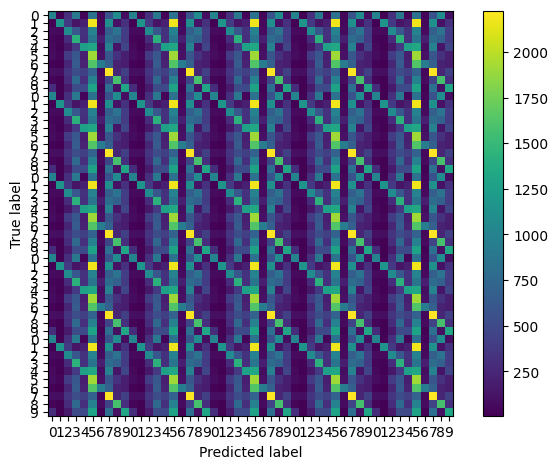

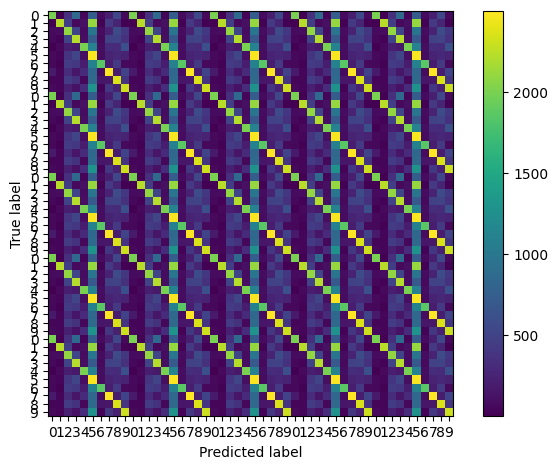

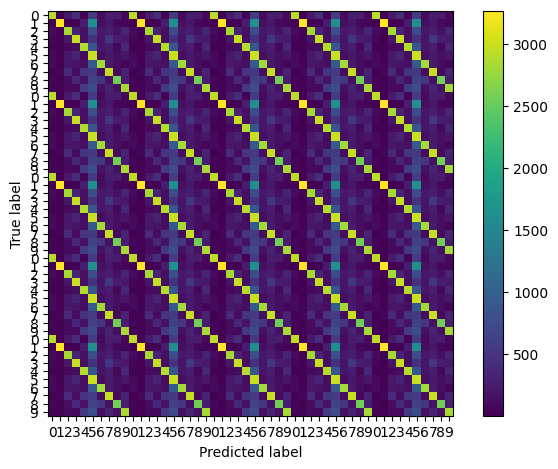

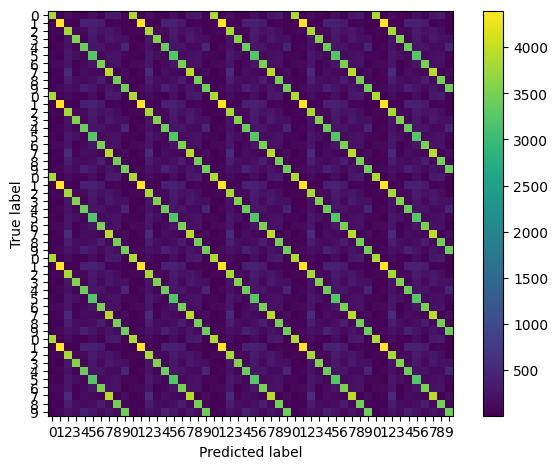

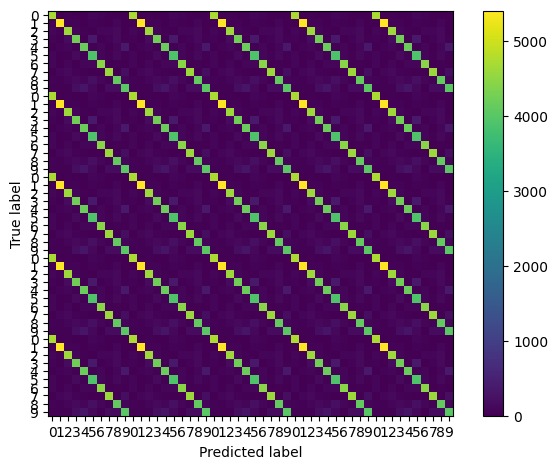

In [12]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [13]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [14]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [15]:
all_loss_components = strategy.get_store_loss()

In [16]:
weights = model_plugins[0].weights

# Store metrics

In [17]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "all_loss_components": all_loss_components,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))